# Capstone 2 Modeling

In this notebook I'm going to prepare and evaluate several different models. Each model will be run across a range of hyperparameter values. Also, each model will be applied to 4 sets of outcome and predictor variables. I'll predict DNAtype based on amino acids, DNAtype based on codons, kingdom based on amino acids, and kingdom based on codons. Incorporating both the amino acid and codon data in a single model would be unwarranted, as the amino acid frequencies are linear combinations of the codon frequencies.  I'll begin with some imports:

In [1]:
import pandas as pd
import numpy as np
import xgboost as xg
import matplotlib.pyplot as plt
import hyperopt
from hyperopt import hp
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve, f1_score, auc, accuracy_score, log_loss, classification_report,confusion_matrix,roc_curve,roc_auc_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')



In [2]:
codon_list = ['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG',
       'AUU', 'AUC', 'AUA', 'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC',
       'GCA', 'GCG', 'CCU', 'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA',
       'GGG', 'UCU', 'UCC', 'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA',
       'ACG', 'UAU', 'UAC', 'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU',
       'CAC', 'AAA', 'AAG', 'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU',
       'GAC', 'GAA', 'GAG', 'UAA', 'UAG', 'UGA']

amino_list = ['alanine', 'arginine',
       'asparagine', 'aspartic acid', 'cysteine', 'glutamine', 'glutamic acid',
       'glycine', 'histidine', 'isoleucine', 'leucine', 'lysine', 'methionine',
       'phenylalanine', 'proline', 'serine', 'threonine', 'tryptophan',
       'tyrosine', 'valine', 'start', 'stop']

In [3]:
dnacols = ['D_chloroplast', 'D_genomic', 'D_mitochondrial']
kingcols = ['K_bacteria', 'K_virus', 'K_plant', 'K_vertebrate', 'K_invertebrate',
            'K_mammal', 'K_bacteriophage', 'K_rodent', 'K_primate', 'K_archaea']


In [4]:
# importing the csv from the preprocessing notebook
cu = pd.read_csv('codon_usage3.csv', index_col='Unnamed: 0')
cu.head()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,K_plant,K_primate,K_rodent,K_vertebrate,K_virus,D_chloroplast,D_genomic,D_mitochondrial,KingLabel,DNALabel
0,virus,genomic,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0,0,0,0,1,0,1,0,9,1
1,virus,genomic,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0,0,0,0,1,0,1,0,9,1
2,virus,genomic,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,0.00782,...,0,0,0,0,1,0,1,0,9,1
3,virus,genomic,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0,0,0,0,1,0,1,0,9,1
4,virus,genomic,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0,0,0,0,1,0,1,0,9,1


In [5]:
# am having some problems with NA popping up after train_test_split!
cu.isna().sum().sum()

0

In [6]:
list(cu.columns)

['Kingdom',
 'DNAtype',
 'SpeciesID',
 'Ncodons',
 'SpeciesName',
 'UUU',
 'UUC',
 'UUA',
 'UUG',
 'CUU',
 'CUC',
 'CUA',
 'CUG',
 'AUU',
 'AUC',
 'AUA',
 'AUG',
 'GUU',
 'GUC',
 'GUA',
 'GUG',
 'GCU',
 'GCC',
 'GCA',
 'GCG',
 'CCU',
 'CCC',
 'CCA',
 'CCG',
 'UGG',
 'GGU',
 'GGC',
 'GGA',
 'GGG',
 'UCU',
 'UCC',
 'UCA',
 'UCG',
 'AGU',
 'AGC',
 'ACU',
 'ACC',
 'ACA',
 'ACG',
 'UAU',
 'UAC',
 'CAA',
 'CAG',
 'AAU',
 'AAC',
 'UGU',
 'UGC',
 'CAU',
 'CAC',
 'AAA',
 'AAG',
 'CGU',
 'CGC',
 'CGA',
 'CGG',
 'AGA',
 'AGG',
 'GAU',
 'GAC',
 'GAA',
 'GAG',
 'UAA',
 'UAG',
 'UGA',
 'alanine',
 'arginine',
 'asparagine',
 'aspartic acid',
 'cysteine',
 'glutamine',
 'glutamic acid',
 'glycine',
 'histidine',
 'isoleucine',
 'leucine',
 'lysine',
 'methionine',
 'phenylalanine',
 'proline',
 'serine',
 'threonine',
 'tryptophan',
 'tyrosine',
 'valine',
 'start',
 'stop',
 'K_archaea',
 'K_bacteria',
 'K_bacteriophage',
 'K_invertebrate',
 'K_mammal',
 'K_plant',
 'K_primate',
 'K_rodent',
 'K_ver

In [7]:
cu['KingLabel'].value_counts()

1    2918
9    2832
5    2490
8    2077
3    1333
4     572
2     220
7     215
6     180
0     126
Name: KingLabel, dtype: int64

In [8]:
# it could be useful to store the results for all of these models 
# some of these will be dict()s - which may be a challenge, but seems like the best solution
# I hate having model_id as a column but I see no good alternative

r_cols = ['model_id', 'model_type', 'inputs', 'outputs', 'hyperparameters', 'assessment', 'start_time', 'run_time'] 
results = pd.DataFrame(columns = r_cols)

results


,model_id,model_type,inputs,outputs,hyperparameters,assessment,start_time,run_time


## Principal Component Analysis

component: 1 var exp: 0.3601442991564971
component: 2 var exp: 0.2258043669620905
component: 3 var exp: 0.06282672182138149
component: 4 var exp: 0.03781507189235847
component: 5 var exp: 0.028781073994357288
component: 6 var exp: 0.022230274710130574
component: 7 var exp: 0.021106469788188323
component: 8 var exp: 0.017959417224878288
0.7766676955498819


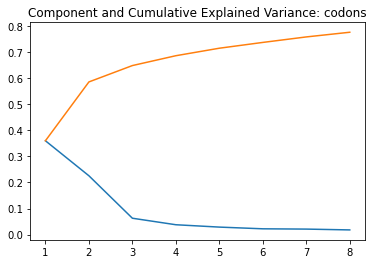

In [9]:
# it could also be interesting at this stage to try PCA:

c = 8
pca = PCA(n_components=c)
pca_fit = pca.fit_transform(cu[codon_list].values)

plt.plot(range(1,c+1), pca.explained_variance_ratio_)
plt.plot(range(1,c+1), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component and Cumulative Explained Variance: codons")

for i in range(0,c):
    print('component:', i+1, 'var exp:', pca.explained_variance_ratio_[i])

print(sum(pca.explained_variance_ratio_))

I neglected to use StandardScaler() first. It's interesting to see just how much these variance components are inflated in the absence of standardization.  Let's try again.

component: 1 var exp: 0.2979106347251254
component: 2 var exp: 0.18665155166764894
component: 3 var exp: 0.05561273748424152
component: 4 var exp: 0.040281561259331244
component: 5 var exp: 0.03458748514926063
component: 6 var exp: 0.02979431787597591
component: 7 var exp: 0.023204131230271
component: 8 var exp: 0.022111837231254473
0.6901542566231091


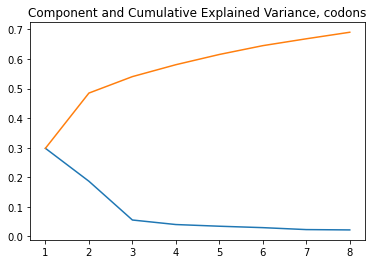

In [10]:
ss = StandardScaler()
codon_ss = ss.fit_transform(cu[codon_list])

c = 8
pca = PCA(n_components=c)
pca_fit = pca.fit_transform(codon_ss)

plt.plot(range(1,c+1), pca.explained_variance_ratio_)
plt.plot(range(1,c+1), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component and Cumulative Explained Variance, codons")

for i in range(0,c):
    print('component:', i+1, 'var exp:', pca.explained_variance_ratio_[i])

print(sum(pca.explained_variance_ratio_))

component: 1 var exp: 0.3348436132240785
component: 2 var exp: 0.16019205982790727
component: 3 var exp: 0.07964782429298155
component: 4 var exp: 0.07353787034124777
component: 5 var exp: 0.05286574544731835
component: 6 var exp: 0.04626115090782696
component: 7 var exp: 0.03544119050786368
component: 8 var exp: 0.03414578447845438
0.8169352390276786


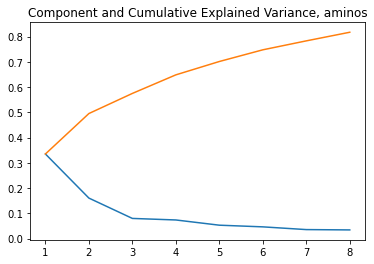

In [11]:
# let's also try this on aminos

ss = StandardScaler()
amino_ss = ss.fit_transform(cu[amino_list])

c = 8
pca = PCA(n_components=c)
pca_fit = pca.fit_transform(amino_ss)

plt.plot(range(1,c+1), pca.explained_variance_ratio_)
plt.plot(range(1,c+1), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component and Cumulative Explained Variance, aminos")

for i in range(0,c):
    print('component:', i+1, 'var exp:', pca.explained_variance_ratio_[i])

print(sum(pca.explained_variance_ratio_))

If we apply the 'elbow method' as one might in, say, k-means clustering, it suggests that applying models to just 3 principal components might be useful.  Still, this only explains only 69% of the variance - if we extend this graph to many components, it has a very long tail.  I'm unconvinced that it would really be beneficial to apply some kind of dimensionality reduction.  But I might return to this later.

# Applying some ML models

I'm going to begin by setting aside a split for final testing across all models.  Because the models are being tested against four conditions (predicting DNAtype and kingdom by aminos and codons) this is a bit complicated.  Instead of creating four separate test split sets (each with X_test and y_test) I'm going to create a test set dataframe.


In [12]:
# I'm going to store the training splits in the original cu dataframe to avoid having to recode everything.
# But I'd like to retain the complete dataframe, it might prove useful.

cufull=cu
cufull.head()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,K_plant,K_primate,K_rodent,K_vertebrate,K_virus,D_chloroplast,D_genomic,D_mitochondrial,KingLabel,DNALabel
0,virus,genomic,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0,0,0,0,1,0,1,0,9,1
1,virus,genomic,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0,0,0,0,1,0,1,0,9,1
2,virus,genomic,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,0.00782,...,0,0,0,0,1,0,1,0,9,1
3,virus,genomic,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0,0,0,0,1,0,1,0,9,1
4,virus,genomic,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0,0,0,0,1,0,1,0,9,1


In [13]:
cufull.isna().sum().sum()

0

In [14]:
all_X = codon_list + amino_list + ['Ncodons']
all_Y = kingcols + dnacols + ['Kingdom', 'DNAtype', 'KingLabel', 'DNALabel']
testset = pd.DataFrame(columns = all_X + all_Y)
cu = pd.DataFrame(columns = all_X + all_Y)
cu[all_X], testset[all_X], cu[all_Y], testset[all_Y] = train_test_split(cufull[all_X], cufull[all_Y], test_size=0.15, random_state=1371)



In [15]:
cu.shape

(11018, 104)

In [16]:
testset.shape

(1945, 104)

In [17]:
cu.isna().sum().sum()

0

In [18]:
testset.isna().sum().sum()

0

Finally this checks out - I was having a persistent problem with NaN's appearing after the split.  It's not happening now, but I have no idea what was producing them.

### K-Nearest Neighbors

K-NN might not be the model type most likely to prove useful, but it has only a single hyperparameter (k, the number of neighbors) to consider.  I'll incorporate everything I need to do into a simple function, this will help avoid tragic mistakes and simplify the work.

In [19]:
def tvts(X, y, val_p=0.15, test_p=0.15, rand=0):
    '''Three way train-validation-test split function'''
    first_split = val_p + test_p
    second_split = test_p / first_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=first_split, random_state=rand)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=second_split, random_state=rand+1)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [20]:
# test it
outs = tvts(cu[amino_list], cu[kingcols])

In [21]:
for out in outs:
    print(len(out))

7712
1653
1653
7712
1653
1653


Seems to work.

In [22]:
def scale_all(X_train, X_val, X_test):
    '''uses StandardScaler() to fit_transform X_train, and then transform X_val and X_test'''
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_val = ss.transform(X_val)
    X_test = ss.transform(X_test)
    return X_train, X_val, X_test


In [23]:
def scale_tv(X_train, X_val):
    '''uses StandardScaler() to fit_transform X_train and transform X_val'''
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_val = ss.transform(X_val)
    return X_train, X_val

In [24]:
'''It is EXTREMELY PAINFUL to me that it proved necessary to include Xn and yn to represent the NAMES of the 
parameters X and y in the function below.  I looked long and hard and ultimately in vain for a clean, simple way
to obtain the name of a variable as a string.  Perhaps this is possible, but I was more concerned about getting
the function to work.''' 

def knn_fit(y, X, yn='', Xn='', max_k=8, tts_random_state=0, test_id=0, do_plots=False):
    '''Fits a k-nearest neighbors model and returns to results dataframe.'''
    # split all data
    X_train, X_val, y_train, y_val = train_test_split(cu[X], cu[y], test_size=0.15, random_state=tts_random_state)
    # scale X data
    X_train, X_val, X_test = scale_all(X_train, X_val, testset[X])
    
    y_test = testset[y]
    
    output = pd.DataFrame(columns=r_cols)
    train_a, val_a, test_a, train_f1, val_f1, test_f1, train_ra, val_ra, test_ra = ([] for i in range(9))
    
    for i in range(1, max_k+1):
        starttime = datetime.now()
        knn = KNeighborsClassifier(i)
        knn.fit(X_train,y_train)
     
        train_pred, test_pred, val_pred = knn.predict(X_train), knn.predict(X_test), knn.predict(X_val)
      
        
        train_prob_pred = knn.predict_proba(X_train)
        test_prob_pred = knn.predict_proba(X_test)
        val_prob_pred = knn.predict_proba(X_val)
        
        test_a.append(accuracy_score(y_test, test_pred))
        train_a.append(accuracy_score(y_train, train_pred))
        val_a.append(accuracy_score(y_val, val_pred))
        
        test_f1.append(f1_score(y_test, test_pred, average='micro'))
        train_f1.append(f1_score(y_train, train_pred, average='micro'))
        val_f1.append(f1_score(y_val, val_pred, average='micro'))
        
        # according to the sklearn docs, roc_auc requires predict_proba; this failed to work
        test_ra.append(roc_auc_score(y_test, test_pred, average='weighted', multi_class='ovo'))
        train_ra.append(roc_auc_score(y_train, train_pred, average='weighted', multi_class='ovo'))
        val_ra.append(roc_auc_score(y_val, val_pred, average='weighted', multi_class='ovo'))
        
        item = [test_id, 'kNN', Xn, yn, {'k':i}, {'train_f1':train_f1[-1], 'val_f1':val_f1[-1], 'test_f1':test_f1[-1],  
                                                  'train_accuracy':train_a[-1], 'val_accuracy':val_a[-1],'test_accuracy':test_a[-1], 
                                                  'train_roc_auc':test_ra[-1], 'val_roc_auc':val_ra[-1], 'test_roc_auc':test_ra[-1]},
                                                    starttime, datetime.now()-starttime]
        itemdict = dict(zip(r_cols, item))
        output = output.append(itemdict, ignore_index=True)

    if do_plots == True:
        title = 'k-NN predicting ' + yn + ' using ' + Xn
        line1, = plt.plot(range(1, max_k+1), train_a, 'b')
        line2, = plt.plot(range(1, max_k+1), val_a, 'g')
        line3, = plt.plot(range(1, max_k+1), test_a, 'r')
        plt.legend([line1, line2, line3], ['training accuracy', 'validation accuracy', 'testing accuracy'])
        plt.title(title)
        plt.ylabel('accuracy')
        plt.xlabel('k')
        plt.show() 
        
        line1, = plt.plot(range(1, max_k+1), train_f1, 'b')
        line2, = plt.plot(range(1, max_k+1), val_f1, 'g')
        line3, = plt.plot(range(1, max_k+1), test_f1, 'r')
        plt.legend([line1, line2, line3], ['training F1', 'validation F1', 'testing F1'])
        plt.title(title)
        plt.ylabel('F1')
        plt.xlabel('k')
        plt.show() 
        
        line1, = plt.plot(range(1, max_k+1), train_ra, 'b')
        line2, = plt.plot(range(1, max_k+1), val_ra, 'g')
        line3, = plt.plot(range(1, max_k+1), test_ra, 'r')
        plt.legend([line1, line2, line3], ['training roc_auc', 'validation roc_auc', 'testing roc_auc'])
        plt.title(title)
        plt.ylabel('roc_auc')
        plt.xlabel('k')
        plt.show() 
    
    else:
        pass
    

    return output

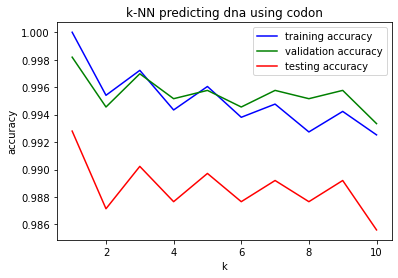

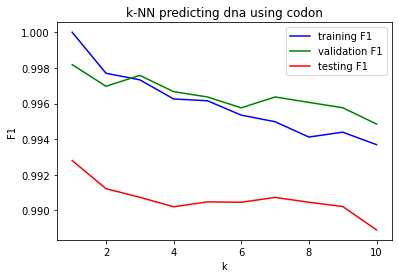

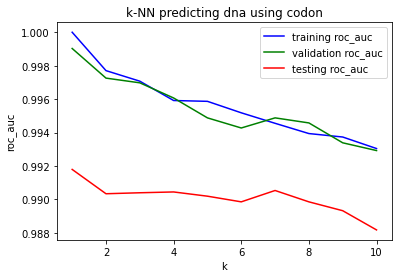

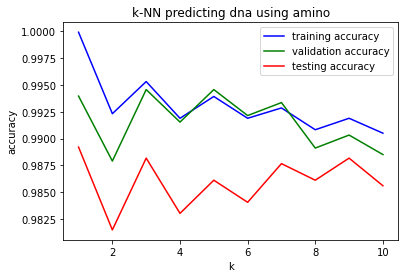

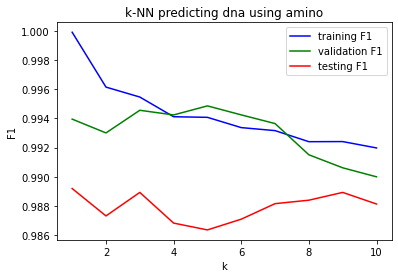

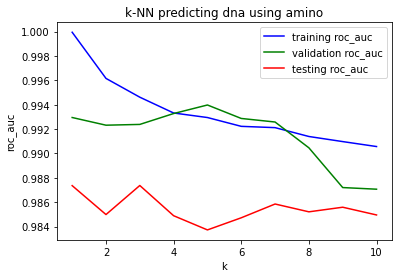

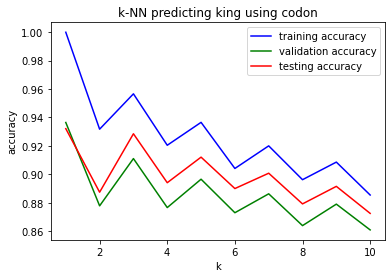

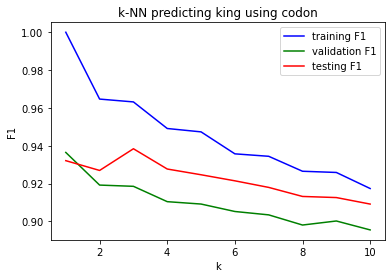

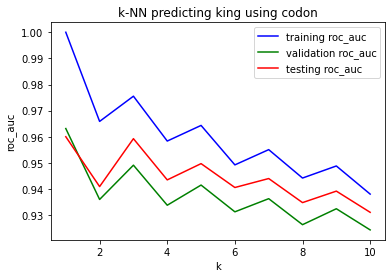

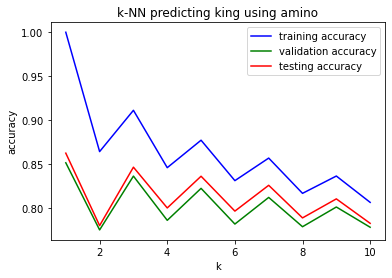

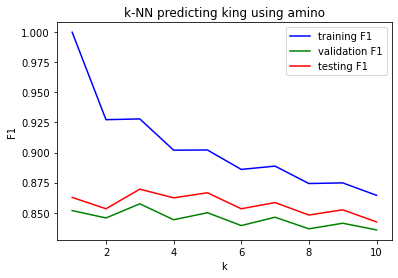

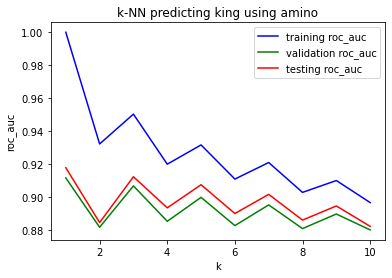

In [25]:
# predicting dna on codon, dna on amino, kingdom on codon, kingdom on amino
results=results.append(knn_fit(dnacols, codon_list, 'dna', 'codon', max_k=10, tts_random_state=535, test_id='1001001', do_plots=True), ignore_index=True)
results=results.append(knn_fit(dnacols, amino_list, 'dna', 'amino', max_k=10, tts_random_state=77, test_id='1002001', do_plots=True), ignore_index=True)
results=results.append(knn_fit(kingcols, codon_list, 'king', 'codon', max_k=10, tts_random_state=300, test_id='1003001', do_plots=True), ignore_index=True)
results=results.append(knn_fit(kingcols, amino_list, 'king', 'amino', max_k=10, tts_random_state=416, test_id='1004001', do_plots=True), ignore_index=True)

In [26]:
list(results.assessment)


[{'train_f1': 1.0,
  'val_f1': 0.9981851179673321,
  'test_f1': 0.9928020565552699,
  'train_accuracy': 1.0,
  'val_accuracy': 0.9981851179673321,
  'test_accuracy': 0.9928020565552699,
  'train_roc_auc': 0.9917948477709857,
  'val_roc_auc': 0.9990284974093264,
  'test_roc_auc': 0.9917948477709857},
 {'train_f1': 0.9976989350885642,
  'val_f1': 0.9969678593086719,
  'test_f1': 0.991223541559112,
  'train_accuracy': 0.995408435664709,
  'val_accuracy': 0.9945553539019963,
  'test_accuracy': 0.987146529562982,
  'train_roc_auc': 0.9903401974341872,
  'val_roc_auc': 0.9972563230928849,
  'test_roc_auc': 0.9903401974341872},
 {'train_f1': 0.9973302007689021,
  'val_f1': 0.9975786924939468,
  'test_f1': 0.9907407407407408,
  'train_accuracy': 0.997223705285638,
  'val_accuracy': 0.9969751966122202,
  'test_accuracy': 0.9902313624678664,
  'train_roc_auc': 0.9903984476847382,
  'val_roc_auc': 0.9969747690668527,
  'test_roc_auc': 0.9903984476847382},
 {'train_f1': 0.9962554830426874,
  'val_

Overall, these scores are higher than expected. It's interesting (and probably important) that higher assessment metrics were obtained in the models predicting DNA type than in the models predicting kingdom.  Perhaps the most noteworthy feature observable from these graphs is that, for the k-NN models predicting DNA type from the amino frequencies, **some of the test scores are higher than the train scores.**  As I understand it, this is a sure sign that something has gone glaringly wrong. What's happening here?  If there were some kind of problem in cleaning or preprocessing, wouldn't the same problem manifest itself in the other three test cases?

**Update**: Having considered that perhaps there was some data leakage from the preprocessing notebook, I removed the StandardScaler() function from that stage and conducted it **after** the train-test split.  The results are the same.  Not understanding why this is happening is like a stone in my shoe, but I have to move on.


In [27]:
results['assessment'][4].get('train_f1')

    

0.9961554891072192

This is as expected; the 'results' dataframe appears to be storing the results as intended.

## Random Forest

I'm going to start with a single random forest model, and assess feature importance.

In [28]:
y = cufull[dnacols]
X = cufull[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=133)
X_train, X_test = scale_tv(X_train, X_test)

rfc = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.989
Random Forest: f1-score=0.991


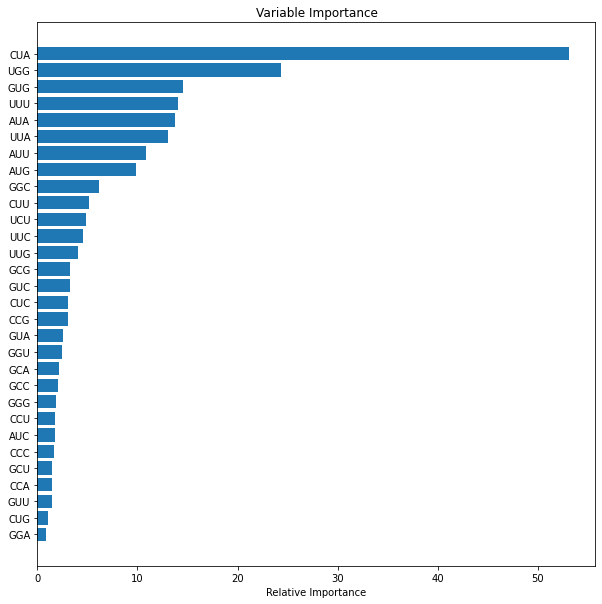

In [29]:
feature_importance = rfc.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Random Forest: Accuracy=0.985
Random Forest: f1-score=0.987


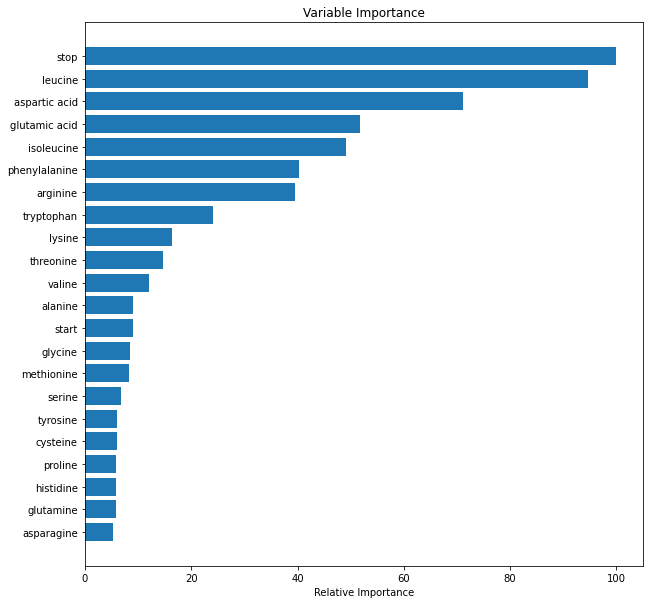

In [30]:
y = cufull[dnacols]
X = cufull[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1863)
X_train, X_test = scale_tv(X_train, X_test)

rfc = RandomForestClassifier(n_estimators=300, random_state = 531,n_jobs=-1)
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

feature_importance = rfc.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Random Forest: Accuracy=0.754
Random Forest: f1-score=0.834


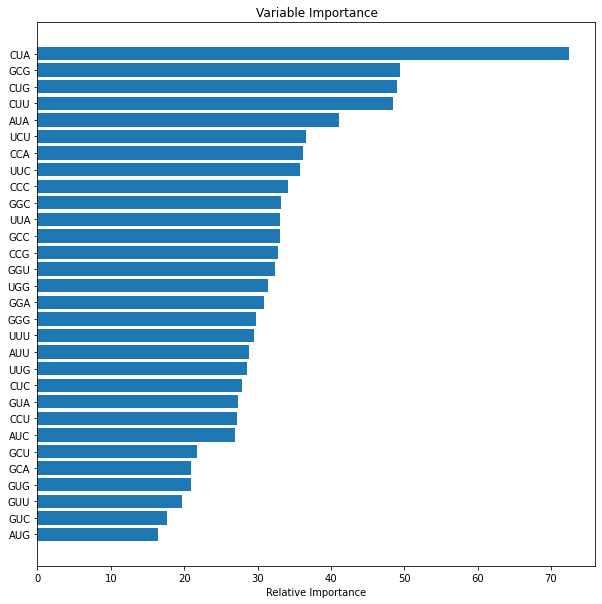

In [31]:
y = cufull[kingcols]
X = cufull[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=133)
X_train, X_test = scale_tv(X_train, X_test)

rfc = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))
feature_importance = rfc.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Random Forest: Accuracy=0.709
Random Forest: f1-score=0.803


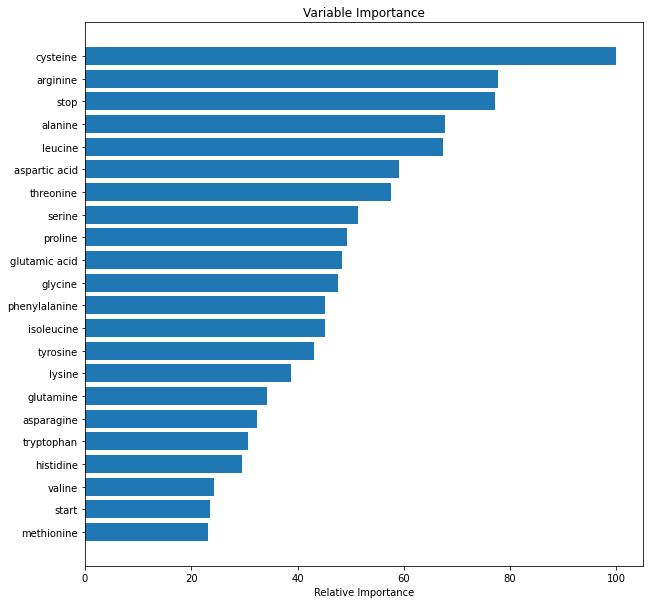

In [32]:
y = cufull[kingcols]
X = cufull[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=154)
X_train, X_test = scale_tv(X_train, X_test)

rfc = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = rfc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))
feature_importance = rfc.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

As when examining the results of PCA:  it's interesting how quickly the relative importance drops off.  It's also worth noting that when trying to predict both DNA type and kingdom, 'CUA' stands out as the most prominent codon.  Perhaps something's up with this?  But let's examine hyperparameter tuning a bit:

In [33]:
# I'll try modifying the same function as above for k-NN

def rfc_fit(y, X, yn='', Xn='', min_n_est=200, n_est_step=20, n_est_steps=11, tts_random_state=0, rfc_random_state=0, test_id=0, do_plots=False):
    
    # split all data
    X_train, X_val, y_train, y_val = train_test_split(cu[X], cu[y], test_size=0.15, random_state=tts_random_state)
    # scale X data
    X_train, X_val, X_test = scale_all(X_train, X_val, testset[X])
    
    y_test = testset[y]
    
    
    train_a, val_a, test_a, train_f1, val_f1, test_f1, train_ra, val_ra, test_ra = ([] for i in range(9))
    
    output = pd.DataFrame(columns=r_cols)
    
    for i in range(n_est_steps):
        starttime = datetime.now()
        rfc = RandomForestClassifier(n_estimators=min_n_est+n_est_step*i, random_state=rfc_random_state, n_jobs=-1)
        rfc.fit(X_train,y_train)
     
        train_pred = rfc.predict(X_train)
        val_pred = rfc.predict(X_val)
        test_pred = rfc.predict(X_test)
        train_prob_pred = rfc.predict_proba(X_train)
        val_prob_pred = rfc.predict_proba(X_val)
        test_prob_pred = rfc.predict_proba(X_test)
    
        test_a.append(accuracy_score(y_test, test_pred))
        val_a.append(accuracy_score(y_val, val_pred))
        train_a.append(accuracy_score(y_train, train_pred))
    
        test_f1.append(f1_score(y_test, test_pred, average='micro'))
        val_f1.append(f1_score(y_val, val_pred, average='micro'))
        train_f1.append(f1_score(y_train, train_pred, average='micro'))
        
        # according to the sklearn docs, roc_auc requires predict_proba; this failed to work
        test_ra.append(roc_auc_score(y_test, test_pred, average='weighted', multi_class='ovo'))
        val_ra.append(roc_auc_score(y_val, val_pred, average='weighted', multi_class='ovo'))
        train_ra.append(roc_auc_score(y_train, train_pred, average='weighted', multi_class='ovo'))
    
        
    for i in range(n_est_steps):
        item = [test_id, 'RFC', Xn, yn, {'n_estimators':min_n_est+n_est_step*i}, {'train_f1':train_f1[i], 'test_f1':test_f1[i],
                                                  'train_accuracy':train_a[i], 'test_accuracy':test_a[i], 
                                                  'train_roc_auc':test_ra[i], 'test_roc_auc':test_ra[i]}, 
                                                    starttime, datetime.now()-starttime]
        itemdict = dict(zip(r_cols, item))
        output = output.append(itemdict, ignore_index=True)

    if do_plots == True:
        title = 'RFC predicting ' + yn + ' using ' + Xn
        line1, = plt.plot(range(n_est_steps), train_a, 'b')
        line2, = plt.plot(range(n_est_steps), val_a, 'g')
        line3, = plt.plot(range(n_est_steps), test_a, 'r')
        plt.legend([line1, line2, line3], ['training accuracy', 'validation accuracy', 'testing accuracy'])
        plt.title(title)
        plt.ylabel('accuracy')
        plt.xlabel('n_estimators')
        plt.show() 
        
        title = 'RFC predicting ' + yn + ' using ' + Xn
        line1, = plt.plot(range(n_est_steps), train_f1, 'b')
        line2, = plt.plot(range(n_est_steps), val_f1, 'g')
        line3, = plt.plot(range(n_est_steps), test_f1, 'r')
        plt.legend([line1, line2, line3], ['training f1', 'validation f1', 'testing f1'])
        plt.title(title)
        plt.ylabel('f1')
        plt.xlabel('n_estimators')
        plt.show() 
        
        title = 'RFC predicting ' + yn + ' using ' + Xn
        line1, = plt.plot(range(n_est_steps), train_ra, 'b')
        line2, = plt.plot(range(n_est_steps), val_ra, 'g')
        line3, = plt.plot(range(n_est_steps), test_ra, 'r')
        plt.legend([line1, line2, line3], ['training roc-auc', 'validation roc-auc', 'testing roc-auc'])
        plt.title(title)
        plt.ylabel('roc_auc')
        plt.xlabel('n_estimators')
        plt.show() 
    
    else:
        pass
    
    return output

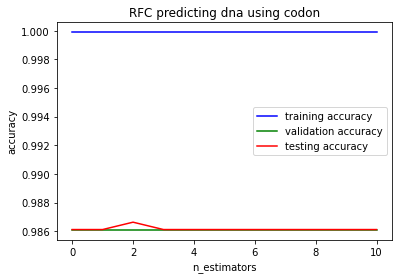

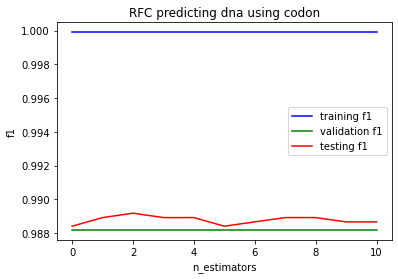

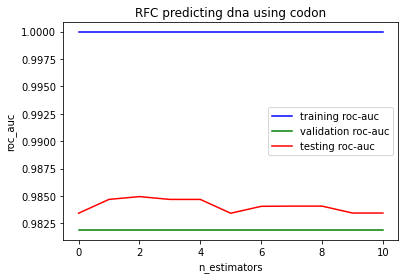

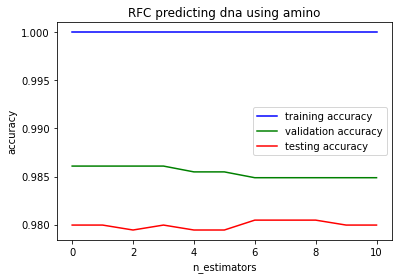

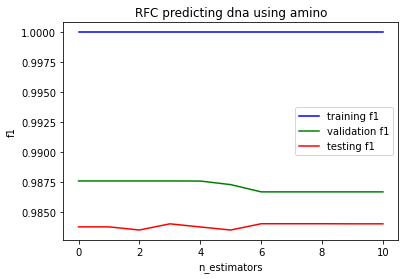

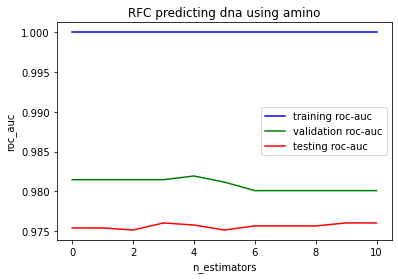

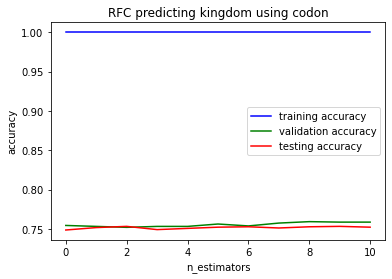

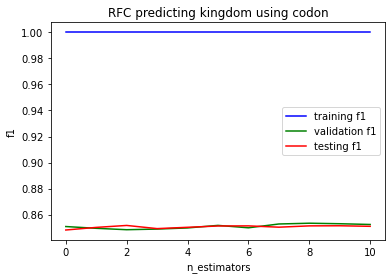

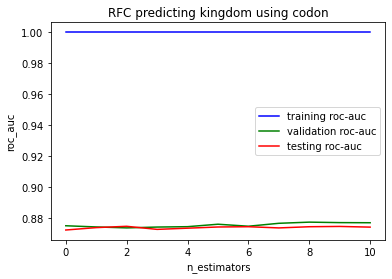

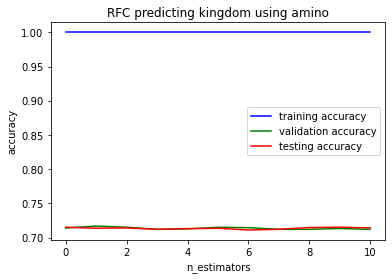

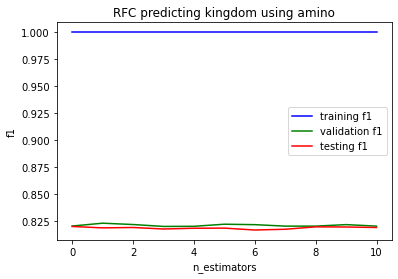

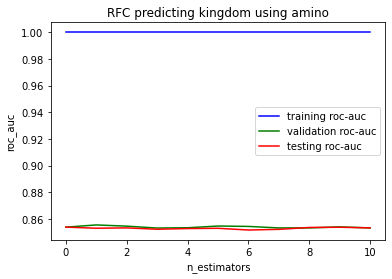

In [34]:
# running the function on:
# y=DNAtype X=codon
results = results.append(rfc_fit(dnacols, codon_list, 'dna', 'codon', test_id='2001001', tts_random_state=55, do_plots=True), ignore_index=True)
# y=DNAtype X=amino
results = results.append(rfc_fit(dnacols, amino_list, 'dna', 'amino', test_id='2002001', tts_random_state=12, do_plots=True), ignore_index=True)
# y=kingdom X=codon
results = results.append(rfc_fit(kingcols, codon_list, 'kingdom', 'codon', test_id='2003001', tts_random_state=63, do_plots=True), ignore_index=True)
# y=kingdom X=amino
results = results.append(rfc_fit(kingcols, amino_list, 'kingdom', 'amino', test_id='2004001', tts_random_state=40, do_plots=True), ignore_index=True)

The only difference seems to be that, when predicting kingdom as opposed to DNAtype, the testing accuracy drops substantially.  In all cases, the uniformly high training accuracy (at of very close to 1) is suspicious.  I suspect that I'll need to adjust some other parameters for the Random Forest classifier in order to  produce a model that's actually useful. Let's examine the results so far:

In [35]:
results

,model_id,model_type,inputs,outputs,hyperparameters,assessment,start_time,run_time
0,1001001,kNN,codon,dna,{'k': 1},"{'train_f1': 1.0, 'val_f1': 0.9981851179673321...",2022-02-23 16:19:29.370324,0 days 00:00:07.892021
1,1001001,kNN,codon,dna,{'k': 2},"{'train_f1': 0.9976989350885642, 'val_f1': 0.9...",2022-02-23 16:19:37.267326,0 days 00:00:08.321290
2,1001001,kNN,codon,dna,{'k': 3},"{'train_f1': 0.9973302007689021, 'val_f1': 0.9...",2022-02-23 16:19:45.595102,0 days 00:00:08.508805
3,1001001,kNN,codon,dna,{'k': 4},"{'train_f1': 0.9962554830426874, 'val_f1': 0.9...",2022-02-23 16:19:54.107866,0 days 00:00:10.072689
4,1001001,kNN,codon,dna,{'k': 5},"{'train_f1': 0.9961554891072192, 'val_f1': 0.9...",2022-02-23 16:20:04.183546,0 days 00:00:10.023518
...,...,...,...,...,...,...,...,...
79,2004001,RFC,amino,kingdom,{'n_estimators': 320},"{'train_f1': 1.0, 'test_f1': 0.816893089190785...",2022-02-23 16:35:08.996943,0 days 00:00:13.449827
80,2004001,RFC,amino,kingdom,{'n_estimators': 340},"{'train_f1': 1.0, 'test_f1': 0.817591499409681...",2022-02-23 16:35:08.996943,0 days 00:00:13.452318
81,2004001,RFC,amino,kingdom,{'n_estimators': 360},"{'train_f1': 1.0, 'test_f1': 0.819817163078737...",2022-02-23 16:35:08.996943,0 days 00:00:13.455654
82,2004001,RFC,amino,kingdom,{'n_estimators': 380},"{'train_f1': 1.0, 'test_f1': 0.819681791396582...",2022-02-23 16:35:08.996943,0 days 00:00:13.459647


84 rows is just what I expect so far.  Let's continue.

## XGBoost


It turns out that XGBClassifier doesn't require, and indeed, can't accept one-hot encoding.  I had to go back to preprocessing and restore the original 'Kingdom' and 'DNAtype' columns.  Also, I discovered that XGBClassifier's own label encoder is deprecated. Eliminating warnings about this requires another import.  **Turns out that, although XGBClassifier still accepted the encoding, this didn't mute the warnings.**

In [36]:
# trying again:  DNAtype on codon_list, default hyperparams
test_id = '3001001'
yn = 'dna'
Xn = 'codon'
y = cu['DNALabel']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13013)
starttime = datetime.now()
xgb = xg.XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
item = [test_id, 'XGB', Xn, yn, {'hyperparameters':'XGBClassifier defaults'}, 
                                {'accuracy':acc, 'f1':f1, 'roc_auc':roc_auc}, 
                                starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

[16:35:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [37]:
results.tail()

,model_id,model_type,inputs,outputs,hyperparameters,assessment,start_time,run_time
80,2004001,RFC,amino,kingdom,{'n_estimators': 340},"{'train_f1': 1.0, 'test_f1': 0.817591499409681...",2022-02-23 16:35:08.996943,0 days 00:00:13.452318
81,2004001,RFC,amino,kingdom,{'n_estimators': 360},"{'train_f1': 1.0, 'test_f1': 0.819817163078737...",2022-02-23 16:35:08.996943,0 days 00:00:13.455654
82,2004001,RFC,amino,kingdom,{'n_estimators': 380},"{'train_f1': 1.0, 'test_f1': 0.819681791396582...",2022-02-23 16:35:08.996943,0 days 00:00:13.459647
83,2004001,RFC,amino,kingdom,{'n_estimators': 400},"{'train_f1': 1.0, 'test_f1': 0.819227366558537...",2022-02-23 16:35:08.996943,0 days 00:00:13.461862
84,3001001,XGB,codon,dna,{'hyperparameters': 'XGBClassifier defaults'},"{'accuracy': 0.9903206291591047, 'f1': 0.99032...",2022-02-23 16:35:23.109111,0 days 00:00:02.903368


Did this work?  Accuracy can be equal to F1, but never greater, right?  Obviously, though, hyperparameter tuning remains a pretty big deal here.

In [38]:
# XGBoost:  DNAcols predicted by aminos
test_id = '3002001'
yn = 'dna'
Xn='amino'
y = cu['DNALabel']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19044)
starttime = datetime.now()
xgb = xg.XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
item = [test_id, 'XGB', Xn, yn, {'hyperparameters':'XGBClassifier defaults'}, {'accuracy':acc, 'f1':f1, 
                                                                               'roc_auc':roc_auc}, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

[16:58:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
# XGBoost:  kingdom predicted by codons
test_id = '3003001'
yn = 'king'
Xn='codon'
y = cu['KingLabel']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19044)
starttime = datetime.now()
xgb = xg.XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
item = [test_id, 'XGB', Xn, yn, {'hyperparameters':'XGBClassifier defaults'}, {'accuracy':acc, 'f1':f1, 
                                                                               'roc_auc':roc_auc}, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

[17:17:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [40]:
# XGBoost:  kingdom predicted by aminos
test_id = '3004001'
yn = 'king'
Xn='amino'
y = cu['KingLabel']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19044)
starttime = datetime.now()
xgb = xg.XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
item = [test_id, 'XGB', Xn, yn, {'hyperparameters':'XGBClassifier defaults'}, {'accuracy':acc, 'f1':f1, 
                                                                               'roc_auc':roc_auc}, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

[13:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [42]:
results.iloc[-1]

model_id                                                     3004001
model_type                                                       XGB
inputs                                                         amino
outputs                                                         king
hyperparameters        {'hyperparameters': 'XGBClassifier defaults'}
assessment         {'accuracy': 0.8608590441621294, 'f1': 0.86085...
start_time                                2022-02-24 13:22:04.865148
run_time                                      0 days 00:00:07.199812
Name: 87, dtype: object

I don't know what to get out of this.  At least I got XGBoost to work; there are so many hyperparameters, though, that I'm not sure how to go about tuning them.  Nor am I sure how to evaluate these models, other than by such metrics as accuracy, F1, etc.

## XGBClassifier using Hyperopt

In [43]:
import hyperopt
from hyperopt import hp
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [45]:
# attempting to use hyperopt to select XGBoost hyperparameters
# starting out by cribbing from https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning


test_id = '3101001'
yn = 'dna'
Xn = 'codon'

y = cu['DNALabel']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6016)
starttime = datetime.now()
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    model=xg.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
    
    return {'loss': -f1, 'accuracy': accuracy, 'roc_auc': roc_auc, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)


item = [test_id, 'XGB', Xn, yn, best_hyperparams, trials, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)


100%|██████████| 100/100 [02:45<00:00,  1.65s/trial, best loss: -0.9800362976406534]


# examine the trials object
I'm going to pause constructing models for a while and just examine the trials object.  I want to be able to get the f1 score, accuracy, and roc_auc for the best_hyperparams model.  This shouldn't be so difficult - but somehow it seems to be.

In [46]:
dir(trials)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_dynamic_trials',
 '_exp_key',
 '_ids',
 '_insert_trial_docs',
 '_trials',
 'aname',
 'argmin',
 'assert_valid_trial',
 'asynchronous',
 'attachments',
 'average_best_error',
 'best_trial',
 'count_by_state_synced',
 'count_by_state_unsynced',
 'delete_all',
 'fmin',
 'idxs',
 'idxs_vals',
 'insert_trial_doc',
 'insert_trial_docs',
 'losses',
 'miscs',
 'new_trial_docs',
 'new_trial_ids',
 'refresh',
 'results',
 'source_trial_docs',
 'specs',
 'statuses',
 'tids',
 'trial_attachments',
 'trials',
 'vals',
 'view']

In [47]:
list(results.hyperparameters[88])

['colsample_bytree',
 'gamma',
 'max_depth',
 'min_child_weight',
 'reg_alpha',
 'reg_lambda']

In [48]:
for r in list(results.hyperparameters[88]):
    print(r)
    print(results.hyperparameters[88].get(r))

colsample_bytree
0.8302457765657515
gamma
1.5504806670600395
max_depth
4.0
min_child_weight
1.0
reg_alpha
40.0
reg_lambda
0.5322277906443807


Ok.  One possible solution - and something I should be able to do anyway - is to simply take these parameter values and plug them back into XGBClassifier.

In [49]:
param_string = ""
for r in list(results.hyperparameters[88]):
    param_string += r
    param_string += "="
    param_string += str(results.hyperparameters[88].get(r))
    param_string += ", "
param_string = param_string.rstrip(', ')

In [50]:
param_string

'colsample_bytree=0.8302457765657515, gamma=1.5504806670600395, max_depth=4.0, min_child_weight=1.0, reg_alpha=40.0, reg_lambda=0.5322277906443807'

In [ ]:
# this failed: entire param_string was interpreted as objective function

#littletest = xg.XGBClassifier(param_string)

In [ ]:
littletest.fit(X_train, y_train)

# Note:  the above model did NOT import the hyperparameters correctly!

In [ ]:
results.hyperparameters[88]

In [ ]:
new_string = "lt = xg.XGBClassifier("+param_string+")"
new_string

In [ ]:
eval(new_string)

I guess that wasn't going to work either.

In [51]:
hparams = []
for r in list(results.hyperparameters[88]):
    hparams.append(r)
hparams

['colsample_bytree',
 'gamma',
 'max_depth',
 'min_child_weight',
 'reg_alpha',
 'reg_lambda']

This is going nowhere.  But I feel - again - like there should be a way to use the name of a variable as a string, or vice-versa...

In [52]:
# there has GOT to be a more systematic way to do this!
colsample_bytree = results.hyperparameters[88].get('colsample_bytree')
gamma = results.hyperparameters[88].get('gamma')
max_depth = int(results.hyperparameters[88].get('max_depth'))
min_child_weight = results.hyperparameters[88].get('min_child_weight')
reg_alpha = int(results.hyperparameters[88].get('reg_alpha'))
reg_lambda = results.hyperparameters[88].get('reg_lambda')

In [53]:
test2 = xg.XGBClassifier(colsample_bytree=colsample_bytree, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, reg_alpha=reg_alpha, reg_lambda=reg_lambda)

In [54]:
test2

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8302457765657515,
              enable_categorical=False, gamma=1.5504806670600395, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=4,
              min_child_weight=1.0, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=40,
              reg_lambda=0.5322277906443807, scale_pos_weight=None,
              subsample=None, tree_method=None, validate_parameters=None,
              verbosity=None)

In [55]:
test2.fit(X_train, y_train)

[19:08:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8302457765657515,
              enable_categorical=False, gamma=1.5504806670600395, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=40, reg_lambda=0.5322277906443807,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [56]:
y_pred = test2.predict(X_test)
y_prob = test2.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
print("accuracy:", accuracy, "f1:", f1, "roc_auc:", roc_auc)

accuracy: 0.984875983061101 f1: 0.984875983061101 roc_auc: 0.9985711967203124


In [57]:
test3 = xg.XGBClassifier(colsample_bytree=colsample_bytree, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, reg_alpha=reg_alpha, reg_lambda=reg_lambda)

In [58]:
test3.fit(X_train, y_train)
y_pred = test2.predict(X_test)
y_prob = test2.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
print("accuracy:", accuracy, "f1:", f1, "roc_auc:", roc_auc)

[19:13:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 0.984875983061101 f1: 0.984875983061101 roc_auc: 0.9985711967203124


# another problem
I can't help but note that the "best loss" produced in the hyperopt iterations that produced these hyperparameter values is -0.9800.  With my loss function being the (negative) F1 score, why isn't the F1 score here equal to 0.9800?  Something isn't adding up.

However, I'm going to go with it for now - this method works, however clumsily.  It's awful having to enumerate the hyperparameters explicitly.

In [ ]:
# DNA on amino 

test_id = '3102001'
yn = 'dna'
Xn = 'amino'

y = cu['DNAtype']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6016)
starttime = datetime.now()

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    model=xg.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
    return {'loss': -f1, 'accuracy': accuracy, 'roc_auc': roc_auc, 'status': STATUS_OK }


trials = Trials()

best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)

item = [test_id, 'XGB', Xn, yn, best_hyperparams, trials, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)


Interesting.  Hyperopt optimizes to radically different hyperparameters using  F1 compared to accuracy.  Let's see if this holds across the other three tests to be run.

In [ ]:
# kingdom on codons

test_id = '3103001'
yn = 'kingdom'
Xn = 'codon'

y = cu['Kingdom']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1613)
starttime = datetime.now()
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    model=xg.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
    return {'loss': -f1, 'accuracy': accuracy, 'roc_auc': roc_auc, 'status': STATUS_OK }


trials = Trials()

best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)

item = [test_id, 'XGB', Xn, yn, best_hyperparams, trials, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

In [ ]:
# kingdom on amino

test_id = '3104001'
yn = 'kingdom'
Xn = 'amino'

y = cu['Kingdom']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6016)
starttime = datetime.now()

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    model=xg.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    roc_auc = roc_auc_score(y_test, y_prob, average='weighted', multi_class='ovo')
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)

item = [test_id, 'XGB', Xn, yn, best_hyperparams, trials, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

In [ ]:
results.tail(10)

In [ ]:
assess = results['assessment']
for i in range(1,11):
    print(assess.iloc[-i])

In [ ]:
hyper = results['hyperparameters']
for i in range(1,11):
    print(hyper.iloc[-i])

Ok, this is very clearly a problem:  the last five models trained have **exactly** the same accuracy, f1, and roc_auc; the hyperparameter values are distinct. In fact, they're quite different.  This is not plausible - something has gone wrong.  I don't think these hyperopt runs are saving the assessment scores that I intend, they're saving these values from the last run I conducted before using hyperopt.  I'm going to need to examine the Trials() objects.

In [ ]:
trials.results

In [ ]:
trials.average_best_error()

## Some concerns that seem pretty serious to me:
1. Apparently, I can get the "average_best_error()" method returned for a Trials() object.  But this, apparently, is only going to give me the metric I'm returning as the loss function.  Can I incorporate other measures (accuracy, roc_auc) into the return that provides the .results attribute in Trials()?  Or is there some better, cleaner way to obtain the measures I want for the 'best hyperparameters' case?
2. Of more practical concern: I was expecting the loss function to bounce around a little, but generally to trend toward some kind of minimum.  I don't see that **at all** in the above results - which makes me think that the problem isn't at all that max_evals is set too low.  (In some sandboxing, I found quite different results, but this was using hyperopt on simple algebraic functions of one variable.)  It really looks like the loss function is just bouncing around, as though hyperopt is just making shots in the dark.  I have to seriously question whether I would obtain even slightly consistent results if I were to repeat the optimization.
3. If the average_best_error() provided above is correct, it corresponds to an F1 score of 0.7154.  This is mediocre at best, and, most troubling:  it's **substantially** lower than the F1 score (0.8704) for the corresponding XGBClassifier model that I ran using default hyperparameters - with no optimization of any kind.  Why would optimizing over a hyperparameter space give me WORSE results than using the defaults?
4.  2 & 3 together suggest there is something wrong with this implementation of hyperopt; I've got to figure out what.  

## MLP Classifier

In [ ]:
# I'm going to begin with a naive instance, using defaults.  MLPClassifier has a lot of hyperparameters.
# Next try to apply hyperopt


test_id = '4001001'
yn = 'dna'
Xn = 'codon'
y = cu[dnacols]
X = cu[codon_list]

starttime = datetime.now()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9091)

mlp = MLPClassifier()
mlp.fit(X_train, y_train)
print(mlp)

y_pred = mlp.predict(X_test)
y_prob = mlp.
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print("Accuracy:", acc, "F1:", f1)

item = [test_id, 'MLP', Xn, yn, best_hyperparams, trials, starttime, datetime.now()-starttime]
itemdict = dict(zip(r_cols, item))
results = results.append(itemdict, ignore_index=True)

In [ ]:
mlp.__dict__


Obviously there's a lot to explore in the MLPClassifier object; I need to read a lot more documentation.  Let's see if I can implement hyperopt over some of the hyperparameter space.

In [ ]:

y = cu['DNAtype']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6919)

space={'hidden_layer_sizes': hp.quniform("hidden_layer_sizes", 50, 150, 1),
       'activation': hp.choice('activation', ['relu', 'tanh', 'logistic']),
        'learning_rate_init': hp.uniform('learning_rate_init', 0.0001,0.01)
    }

def objective(space):
    model=MLPClassifier(
                    hidden_layer_sizes = int(space['hidden_layer_sizes']),
                    activation = space['activation'],
                    learning_rate_init = space['learning_rate_init'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='micro')
    print ("F1 SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)


That took a shockingly long time to run, and I was only including three hyperparameters in the space.  Perhaps more troubling, the 'best hyperparameters' included a value of zero for 'activation' - this isn't one of the values I provided in the space dictionary, NOR is it an admissible parameter value for MLPClassifier, so this is just baffling. It's interesting that absolutely all of the F1 scores listed are very high, regardless of the values chosen by hyperopt.   I'm also uncertain how to isolate the 'best hyperparameters' model so as to get measures like its accuracy and F1, make and assess predictions based on new data, etc.  However, for now, I'm going to see how this works out using amino_list as predictors.

In [ ]:
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4092)

space={'hidden_layer_sizes': hp.quniform("hidden_layer_sizes", 50, 150, 1),
       'activation': hp.choice('activation', ['relu', 'tanh', 'logistic']),
        'learning_rate_init': hp.uniform('learning_rate_init', 0.0001,0.01)
    }

def objective(space):
    model=MLPClassifier(
                    hidden_layer_sizes = int(space['hidden_layer_sizes']),
                    activation = space['activation'],
                    learning_rate_init = space['learning_rate_init'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train)
    

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='micro')
    print ("F1 SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = hyperopt.fmin(fn = objective,
                        space = space,
                        algo = hyperopt.tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)


Again: the F1 scores are all very high and don't vary much, which is somewhat suspicious.  Also, the 'activation' hyperparameter is again yielding an invalid value.  And the optimization is taking a very long time to execute.  Worse, there are other relevant hyperparameters that should be tuned - I need to seek out  a little more information and make sure that nothing's terribly wrong here.  (Or is it normal to get F1 values this high with the MLPClassifier?)

## Naive Bayes

Note before beginning that all naive Bayes models make the assumption of independence among predictor variables.  **We can know to a certainty that this is not the case here**, but, looking at examples of successful applications of naive Bayes models, most of them don't really have independence either.  Nevertheless, such models have proven somewhat successful in practice.

In [ ]:
# trying it on DNA and codons first
# also apparently GaussianNB doesn't work with encoding


y = cu['DNAtype']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101101)

gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred = gnb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print("Accuracy:", acc, "F1:", f1)



It's rather odd that these are both equal.  And, again, I need to figure out which attributes and methods of the gnb model are useful.

In [ ]:
dir(gnb)

In [ ]:
gnb.get_params()

It's shocking that there are only **two** parameters for this model.  Also, how can ANY Bayesian model tell me that 'priors' is 'None'?  It's fundamental to ALL Bayesian methods that there is an assumed prior distribution for any parameter to be estimated.  What does this even mean?  I need to read more about naive Bayes models, obviously.  But for now, it shouldn't be hard to apply this model to the three other potential model classes I'm exploring.

In [ ]:
y = cu['DNAtype']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=109)

gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred = gnb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print("Accuracy:", acc, "F1:", f1)


In [ ]:
y = cu['Kingdom']
X = cu[codon_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=823)

gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred = gnb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print("Accuracy:", acc, "F1:", f1)


In [ ]:
y = cu['Kingdom']
X = cu[amino_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8220)

gnb = GaussianNB()
gnb.fit(X_train, y_train)


y_pred = gnb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')
print("Accuracy:", acc, "F1:", f1)


Ok, so all I'm getting at this point is that the naive Bayes models are scoring FAR higher for predicting 'DNAtype' than for predicting 'Kingdom' - it's also worth noting that in all cases, accuracy and F1 score are coming back exactly equal.  (I need to consider what that means, and why that would be the case for these models.)  